# Replication of the two-asset model in Auclert, Rognile and Straub  (2020)* without sticky information.

*Auclert, Adrien, Matthew Rognlie, and Ludwig Straub. Micro jumps, macro humps: Monetary policy and business cycles in an estimated HANK model. No. w26647. National Bureau of Economic Research, 2020.

This notebook serves as an enviroment to replicate the model but also to get accustomed to the code package and the solution alogorithms.

# Replication settings
(needs to be done before first numba import)

In [1]:
import os
from types import SimpleNamespace

replication_settings = {
    'savefolder': '',   # if empty, the usual "saved" folder is used
    'do_print': False, # TODO: move to update_par. Has no effect atm.
    'update_par': {         # update par for all models
        'start_dbeg_opti': True # use Dbeg that is already optimally distributed along the illiquid asset grid
    },
    'do_tests':{
        'different_dbeg': False  # test if different initial distribution leads to the same ss.D
    },
    'models': {
        'tax_financing': {      # this is the baseline model
            'replicate': True
        },
        'deficit_financing': {  # deficit financing but repayment over time
            'replicate': True,
            'update_par':{
                'phi_G': 1.0
            },
        },
        'deficit_financing_slow_djust': {   # deficit financing but slow repayment over time
            'replicate': False,
            'update_par':{
                'phi_G': 1.0,
                'phi_tau': 0.01
            },
        }
    },
    'disable_jit': False,  # disable numba for easier debugging (at least in Pycharm)
}

if replication_settings['disable_jit']: # disables numba decorator. Needs to be done before numba is imported.
    os.environ['NUMBA_DISABLE_JIT'] = '1'
else:
    os.environ['NUMBA_DISABLE_JIT'] = '0'

# update parameters for
updated_par=replication_settings['update_par']

# Imports

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from tabulate import tabulate
import pandas as pd

from HANKnoStickyModel import HANKnoStickyModelClass

# Model specification
The model has the following key features:
 - incomplete market model
 - two assets
 - sitcky wages and prices
 - capital and investment adjustment costs
 - long-term government debt

In contrast to the original model I will leave out the following:
- sticky information
- permanent heterogeneity

The DAG of the model used in the original paper is:
<img src="images\\DAG_Humps.png" alt="DAG Humps, Jumps" width=800 height=600 />

# Implementation steps
1. Set up the model in a class om the Model.py
    - a "settings()" function with the fundamental settings
        - namespaces
        - specify household variables that will be relevant (grids, policy functions, direct inputs, transition matrix inputs, outputs, intertemporal variables)
        - GE settings (shocks, unknowns, targets)
        - all variables
        - functions to overwrite (solution algorithm, blocks_pre, blocks_post)
    - a "setup()" function which sets baseline parameters
    - "allocate()" function which calls "allcoate_GE()" (see GEModelTools description page 10)
    - overwrite methods ".prephare_hh_ss()" and ".find_ss()"
2.

In [3]:
model = HANKnoStickyModelClass(name='baseline', par=updated_par)

# 1. Find Steady State

In [4]:
model.find_ss(do_print=True)

Find optimal beta for market clearing
final evaluation
household problem in ss solved in 0.8 secs [283 iterations]
household problem in ss simulated in 0.2 secs [251 iterations]
steady state found in 26.7 secs
 beta   = 0.95991659
Implied nu =  1.296
Discrepancy in C =  -0.00000000 ->    -0.000000%
Discrepancy in L =   0.00000000 ->     0.000000%
Discrepancy in A =  -0.00000000 ->    -0.000000%
Market clearing residual =  -0.00000000


The household simulation takes quite a while if the distribution also needs to adjust along the illiquid asset grid, because the parameter $\chi$ is quite small.
Therefore, it saves time to run the simulation with an initial distribution that is already optimized aling the illiquid asset grid. This part of the distribution is analylically available as all households hold the same targat value of illiquid assets in the steady state. This target is given as the amount of illiquid assets in the steady state as the population mass is 1.

In [5]:
# show that starting at the optimized distribution leads to the same result
if replication_settings['do_tests']['different_dbeg']:
    par_diff_init_distr = replication_settings['update_par'].copy()
    par_diff_init_distr['start_dbeg_opti'] = not par_diff_init_distr['start_dbeg_opti']
    model_diff_init_distr = HANKnoStickyModelClass(name='baseline', par=par_diff_init_distr)
    model_diff_init_distr.find_ss(do_print=True)
    diff_D = abs(model.ss.D - model_diff_init_distr.ss.D)
    print(f'Absolute difference in the simulated distributions is {np.sum(diff_D):.10f}')

## Productivity States

In [6]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

In [7]:
# steady state distribution for productivity states
for i_fix in range(par.Nfix):

    beta = par.beta_grid[i_fix]
    print(f'{beta = :.4f}:')

    for z,pr_z in zip(par.z_grid,ss.Dz[i_fix]/np.sum(ss.Dz[i_fix])):
        print(f' Pr[z = {z:.4f}] = {pr_z:.4f}')

print(f'Sum(Pr[z]) = {ss.Dz.sum():.4f}')

beta = 0.9599:
 Pr[z = 0.2595] = 0.0156
 Pr[z = 0.3904] = 0.0938
 Pr[z = 0.5872] = 0.2344
 Pr[z = 0.8833] = 0.3125
 Pr[z = 1.3286] = 0.2344
 Pr[z = 1.9984] = 0.0938
 Pr[z = 3.0060] = 0.0156
Sum(Pr[z]) = 1.0000


In [8]:
# transition probabilites between states
for i_fix in range(par.Nfix):
    tab = np.concatenate((ss.z_trans[i_fix], ss.z_trans[i_fix,:,:].sum(axis=1).reshape(-1,1)), axis=1)
    header = [""] * par.Nz + ["sum"]
    table = tabulate(tab.round(3), tablefmt='simple', headers=header)
    print(table)

                                                   sum
-----  -----  -----  -----  -----  -----  -----  -----
0.902  0.094  0.004  0      0      0      0          1
0.016  0.904  0.078  0.003  0      0      0          1
0      0.031  0.904  0.062  0.002  0      0          1
0      0.001  0.047  0.905  0.047  0.001  0          1
0      0      0.002  0.062  0.904  0.031  0          1
0      0      0      0.003  0.078  0.904  0.016      1
0      0      0      0      0.004  0.094  0.902      1


## Policy functions

In [9]:
c = ss.c[0,:,:,:]
l = ss.l[0,:,:,:]
a = ss.a[0,:,:,:]

### Consumption and savings function at different illiquid asset grids

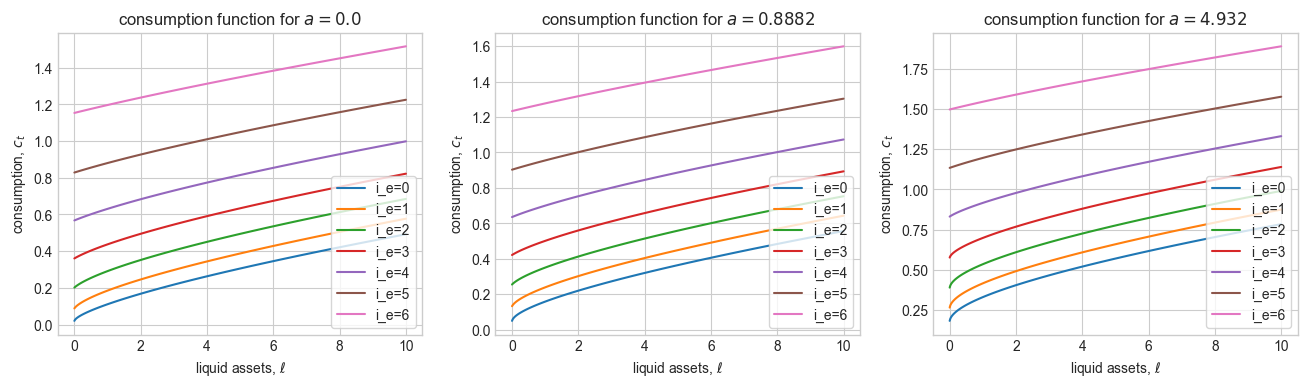

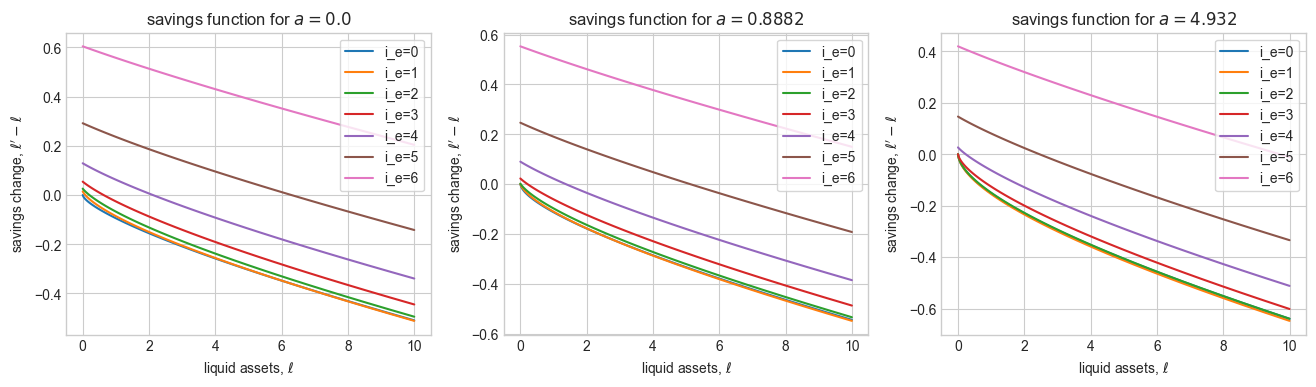

In [10]:
fig = plt.figure(figsize=(16,4),dpi=100)
a_points = [0,20,40]
for i,i_a in enumerate(a_points):
    a_i = par.a_grid[i_a]
    ax = fig.add_subplot(1,len(a_points),i+1)
    ax.set_title(f'consumption function for $a = {a_i:.4}$')
    for i_e in range(par.Nz):
        ax.plot(par.l_grid, c[i_e,:,i_a], label=f'i_e={i_e}')
    ax.legend(frameon=True)
    ax.set_xlabel('liquid assets, $\ell$')
    ax.set_ylabel('consumption, $c_t$')

fig = plt.figure(figsize=(16,4),dpi=100)
a_points = [0,20, 40]
for i,i_a in enumerate(a_points):
    a_i = par.a_grid[i_a]
    ax = fig.add_subplot(1,len(a_points),i+1)
    ax.set_title(f'savings function for $a = {a_i:.4}$')
    for i_e in range(par.Nz):
        ax.plot(par.l_grid, l[i_e,:,i_a]-par.l_grid, label=f'i_e={i_e}')
    ax.legend(frameon=True)
    ax.set_xlabel('liquid assets, $\ell$')
    ax.set_ylabel('savings change, $\ell\'-\ell$')

### Policy function at the steady state

Text(0, 0.5, "savings change, $\\ell'-\\ell$")

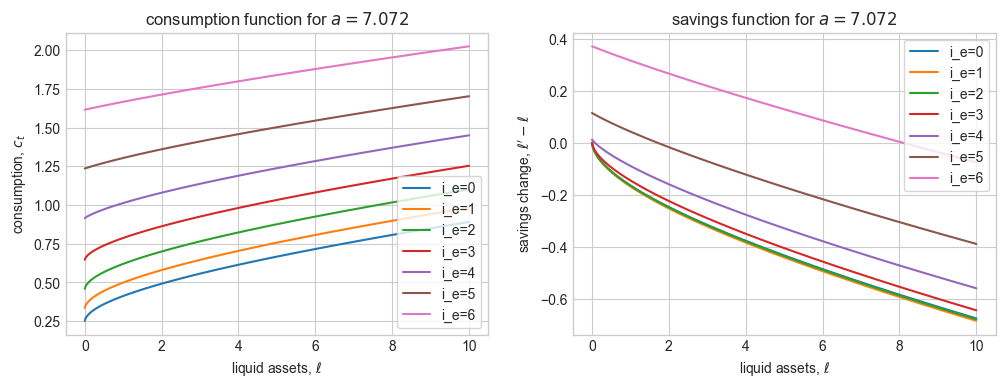

In [11]:
# find closest but smaller grid value to target
i_a_target = np.abs(par.a_grid-ss.A).argmin() # find grid value which is closest to the target
if par.a_grid[i_a_target] > ss.A:
    i_a_target += -1 # select grid value that is smaller than target
assert i_a_target <= par.Na, 'illiquid asset target outside of grid'
# find weights between grid value and target,
    # s.t. w*a_grid[i]+(1-w)*a_grid[i+1] = a_target
i_a_weight = (ss.A-par.a_grid[i_a_target+1]) / (par.a_grid[i_a_target]-par.a_grid[i_a_target+1])

fig = plt.figure(figsize=(12,4),dpi=100)

ax = fig.add_subplot(1,2,1)
ax.set_title(f'consumption function for $a = {ss.A:.4}$')
for i_e in range(par.Nz):
    c1 = c[i_e,:,i_a_target]
    c2 = c[i_e,:,i_a_target+1]
    c_a_ss = i_a_weight*c1 + (1-i_a_weight)*c2
    ax.plot(par.l_grid, c_a_ss, label=f'i_e={i_e}')
ax.legend(frameon=True)
ax.set_xlabel('liquid assets, $\ell$')
ax.set_ylabel('consumption, $c_t$')

ax = fig.add_subplot(1,2,2)
ax.set_title(f'savings function for $a = {ss.A:.4}$')
for i_e in range(par.Nz):
    l1 = l[i_e,:,i_a_target]
    l2 = l[i_e,:,i_a_target+1]
    l_a_ss = i_a_weight*l1 + (1-i_a_weight)*l2
    ax.plot(par.l_grid, l_a_ss-par.l_grid, label=f'i_e={i_e}')
ax.legend(frameon=True)
ax.set_xlabel('liquid assets, $\ell$')
ax.set_ylabel('savings change, $\ell\'-\ell$')

### Policy function for illiquid assets
The policy function for illiquid asset gives next periods illiquid assets given the interest rate for illiquid assets (steady state and contemporaneous), the illiquid asset target and the illiquid asset state.
It is independent of the other state and choice variables.

In [12]:
# check that pol. function for a is independent of c, l and s
for i_z in range(par.Nz-1):
    assert np.sum(a[i_z] - a[i_z+1]) == 0.0, 'policy function for illiquid assets changes with z'
for i_l in range(par.Nl-1):
    assert np.sum(a[:, i_l, :] - a[:, i_l+1, :]) == 0.0, 'policy function for illiquid assets changes with l'

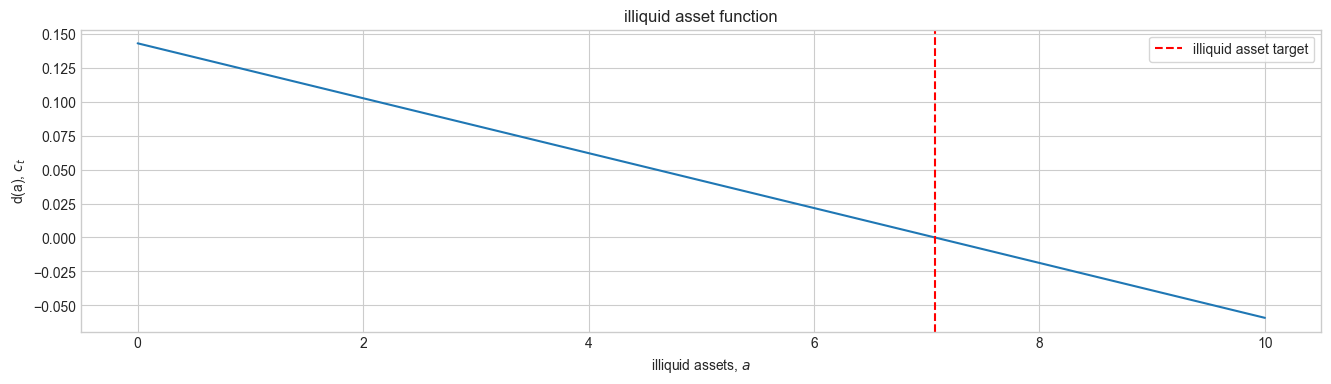

In [13]:
# plot change in illiquid assets
A_target = (par.hh_wealth_Y_ratio-par.L_Y_ratio)
fig = plt.figure(figsize=(16,4),dpi=100)
ax = fig.add_subplot(1,1,1)
ax.set_title(f'illiquid asset function')
ax.plot(par.a_grid, a[0,0,:]-par.a_grid)
ax.axvline(x=A_target, color='red', linestyle='--', label='illiquid asset target')
ax.set_xlabel(f'illiquid assets, $a$')
ax.set_ylabel(f'd(a), $c_t$')
ax.legend(frameon=True)

## Simulation

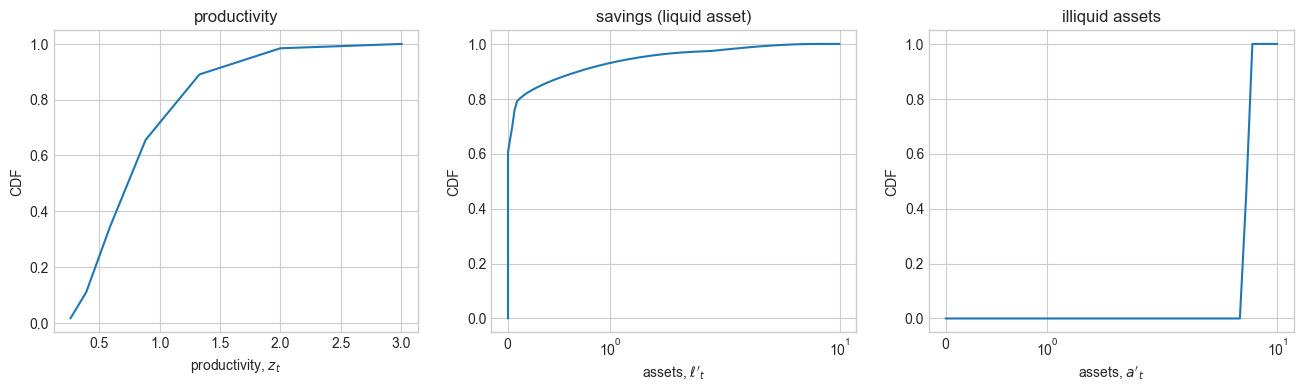

In [14]:
fig = plt.figure(figsize=(16,4),dpi=100)

# a. income
ax = fig.add_subplot(1,3,1)
ax.set_title('productivity')
ax.plot(par.z_grid,np.cumsum(np.sum(ss.D,axis=(0,2,3))))

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. liquid assets
ax = fig.add_subplot(1,3,2)
ax.set_title('savings (liquid asset)')
ax.plot(np.insert(par.l_grid,0,par.l_grid[0]),np.insert(np.cumsum(np.sum(ss.D,axis=(0,1,3))),0,0.0),label='discrete')
ax.set_xlabel('assets, $\ell\'_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

# c. illiquid assets
ax = fig.add_subplot(1,3,3)
ax.set_title('illiquid assets')
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(ss.D,axis=(0,1,2))),0,0.0),label='discrete')
ax.set_xlabel('assets, $a\'_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

In [15]:
# Expected illiquid asset holdings
E_a = (a*ss.D).sum()
print(f'Expected Assets minus target = {E_a - ss.A:.3e}')
d_i_a_target = (ss.D).sum(axis=(0,1,2))[i_a_target]
d_i_a_target_p1 = (ss.D).sum(axis=(0,1,2))[i_a_target+1]
print(f'weight at illiquid asset grids to both sides of the target: {d_i_a_target:.4f} and {d_i_a_target_p1:.4f}, sum {d_i_a_target+d_i_a_target_p1:.4f}')

Expected Assets minus target = 3.997e-14
weight at illiquid asset grids to both sides of the target: 0.4474 and 0.5526, sum 1.0000


### MPCs

In [16]:
# for liquid assets
MPC = np.zeros(ss.D.shape)
dc = (ss.c[:, :, 1:, :] - ss.c[:, :, :-1, :])
l_grid_full = np.repeat(par.l_grid, par.Na).reshape(1,1,par.Nl,par.Na)
dl = (1 + ss.rl) * l_grid_full[:, :, 1:, :] - (1 + ss.rl) * l_grid_full[:, :, :-1, :]
MPC[:, :, :-1, :] = dc / dl
MPC[:, :, -1, :] = MPC[:, :, -2, :]  # assuming constant MPC at end
mean_MPC = np.sum(MPC * ss.D)
# mean_MPC_ann = 1 - (1 - mean_MPC) ** 4
# print(f'mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')
print(f'mean MPC out of liquid assets: {mean_MPC:.3f} (annual terms)')

mean MPC out of liquid assets: 0.463 (annual terms)


In [17]:
# for illiquid assets
MPC = np.zeros(ss.D.shape)
dc = (ss.c[:, :, :, 1:] - ss.c[:, :, :, :-1])
a_grid_full = np.repeat(par.a_grid, par.Nl).reshape(1,1,par.Nl,par.Na).swapaxes(2,3)
da = (1 + ss.ra) * a_grid_full[:, :, :, 1:] - (1 + ss.ra) * a_grid_full[:, :, :, :-1]
MPC[:, :, :, :-1] = dc / da
MPC[:, :, :, -1] = MPC[:, :, :, -2]  # assuming constant MPC at end
mean_MPC = np.sum(MPC * ss.D)
# mean_MPC_ann = 1 - (1 - mean_MPC) ** 4
# print(f'mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')
print(f'mean MPC out of illiquid assets: {mean_MPC:.3f} (annual terms)')

mean MPC out of illiquid assets: 0.036 (annual terms)


# Step 2: Compute Jacobians (incl. tests)

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 1.6 secs
household problem simulated along transition in 2.3 secs



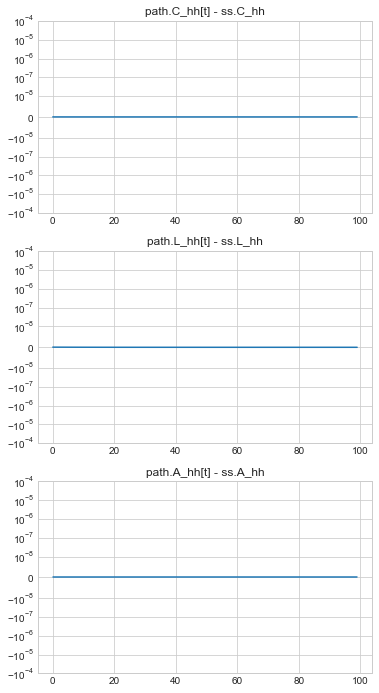

In [18]:
model.test_hh_path()

**Full transition path:**

In [19]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
r              : t0 =  0.0e+00, max abs.  0.0e+00
ra             : t0 =  0.0e+00, max abs.  0.0e+00
rl             : t0 =  0.0e+00, max abs.  0.0e+00
i              : t0 =  0.0e+00, max abs.  0.0e+00
Pi             : t0 =  0.0e+00, max abs.  0.0e+00
Pi_w           : t0 =  0.0e+00, max abs.  0.0e+00
G              : t0 =  0.0e+00, max abs.  0.0e+00
tau            : t0 =  0.0e+00, max abs.  0.0e+00
B              : t0 =  0.0e+00, max abs.  0.0e+00
Y              : t0 =  0.0e+00, max abs.  0.0e+00
N              : t0 =  0.0e+00, max abs.  0.0e+00
I              : t0 =  0.0e+00, max abs.  2.5e-16
K              : t0 =  0.0e+00, max abs.  0.0e+00
Div            : t0 =  0.0e+00, max abs.  2.5e-16
Q              : t0 =  0.0e+00, max abs.  0.0e+00
C              : t0 =  0.0e+00, max abs.  2.0e-15
A              : t0 =  0.0e+00, max abs.  1.1e-13
L              : t0

note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost          : 0 20 50 [computed in 2.3 secs]
finding Jacobian wrt. Z              : 0 20 50 [computed in 1.9 secs]
finding Jacobian wrt. ra             : 0 20 50 [computed in 1.4 secs]
finding Jacobian wrt. rl             : 0 20 50 [computed in 1.7 secs]
household Jacobian computed in 7.5 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for Z               in 0.9 secs
curly_Y and curly_D calculated for ra              in 0.7 secs
curly_Y and curly_D calculated for rl              in 1.5 secs
curly_E calculated in 4.9 secs
builiding blocks combined in 0.2 secs
household Jacobian computed in 8.4 secs

C_hh:
 Z              : cond = 2.5e+00 [mean =  9.7e-03]
 ra             : cond = 1.4e+03 [mean =  6.6e-02]
 rl             : cond = 3.3e+01 [mean =  6.5e-04]

L_hh:
 Z              : cond = 8.5e+00 [mean =  7.0e-03]
 ra         

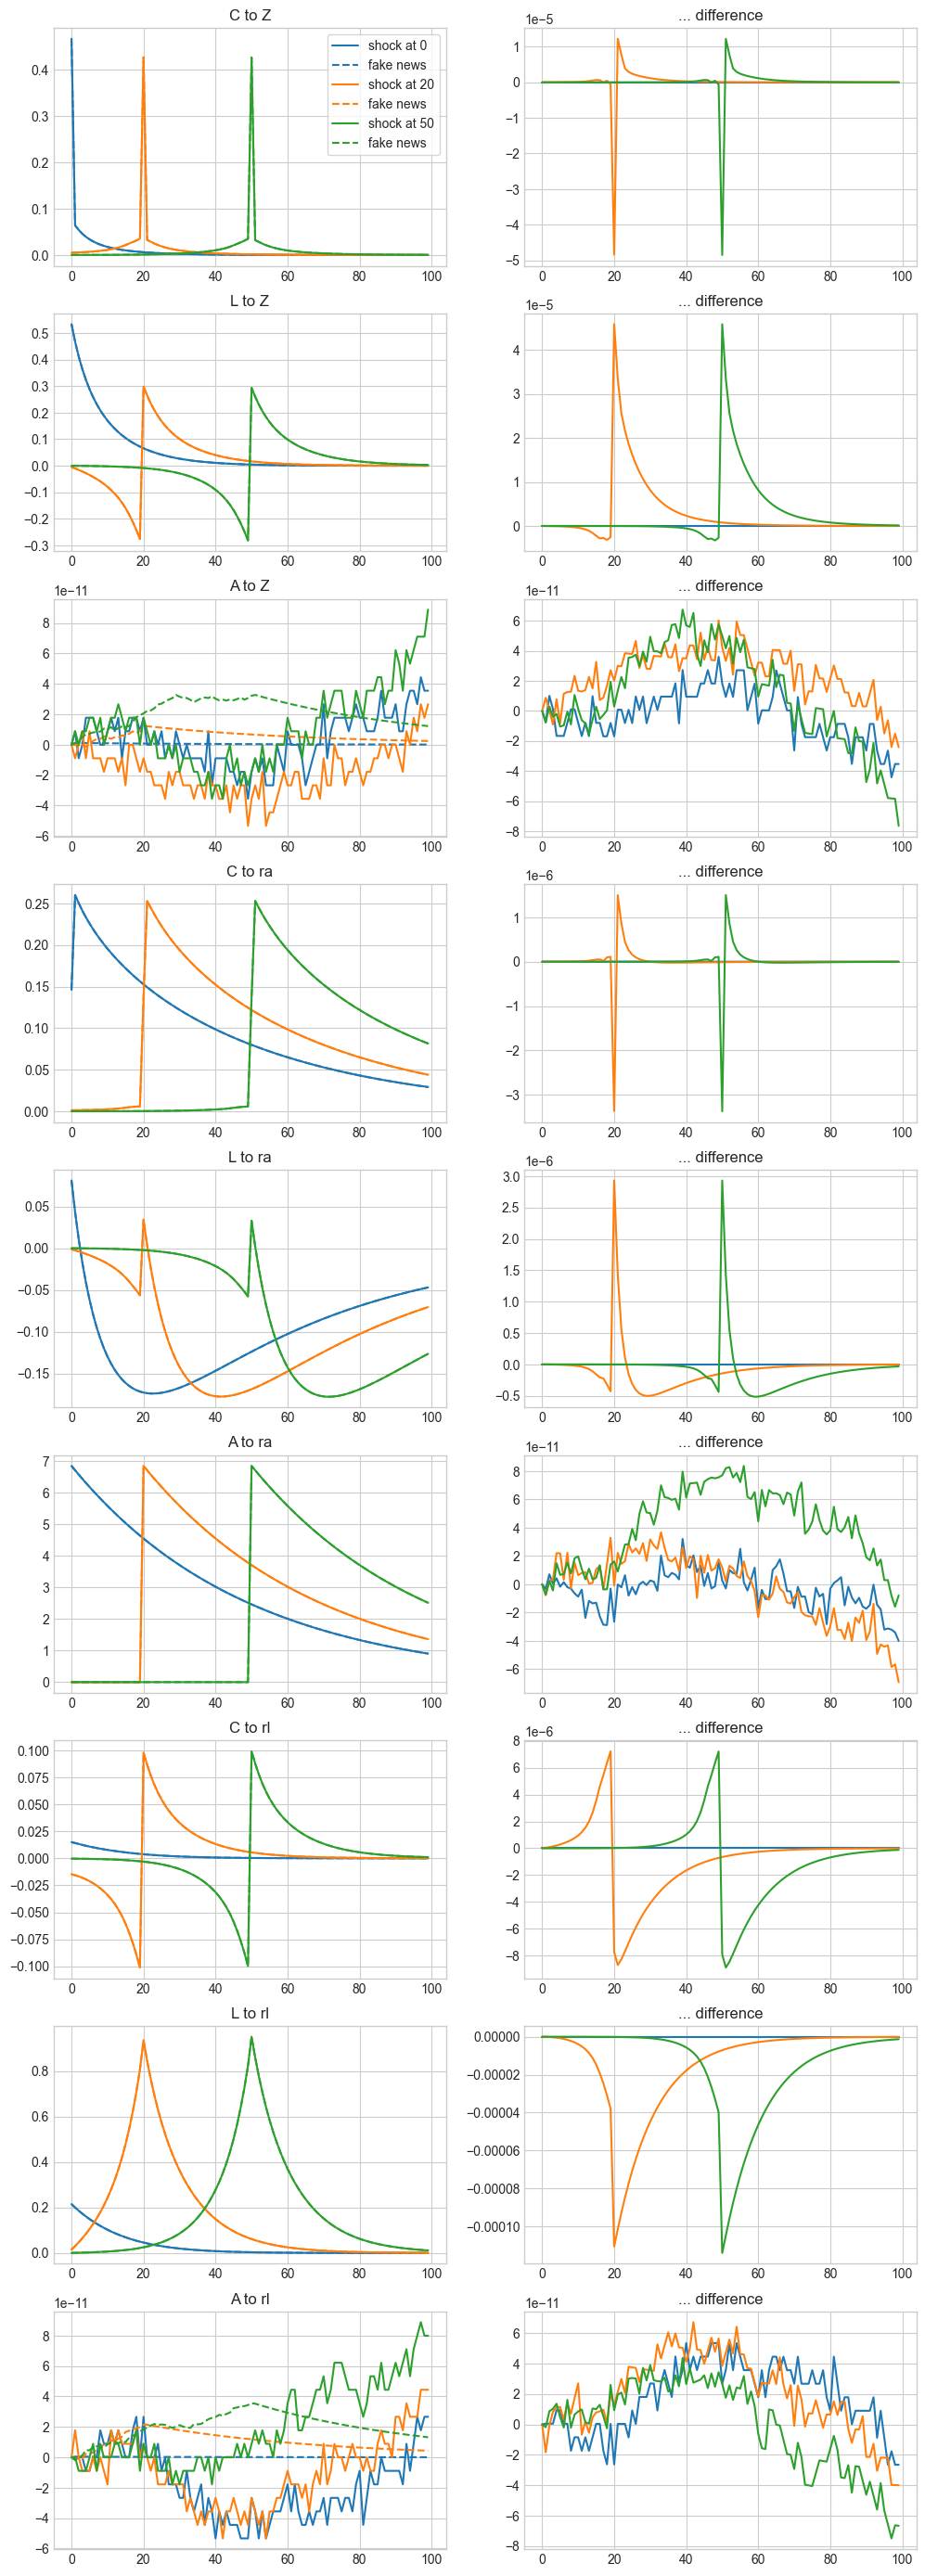

In [20]:
model.test_jacs(s_list=[0,20,50])

# Step 3a: Find non-linear transition_path

In [21]:
model.find_transition_path(do_print=True, do_print_unknowns=True)

finding the transition path:
 it =   0 -> max. abs. error = 1.60e-03
   r              : minval =   0.012 meanval =   0.012 maxval =   0.012
   w              : minval =   0.798 meanval =   0.798 maxval =   0.798
   Y              : minval =   1.000 meanval =   1.000 maxval =   1.000
   0.00e+00 in fisher_res
   0.00e+00 in w_res
   1.60e-03 in clearing_Y
 it =   1 -> max. abs. error = 2.43e-08
   r              : minval =   0.012 meanval =   0.012 maxval =   0.012
   w              : minval =   0.798 meanval =   0.798 maxval =   0.798
   Y              : minval =   1.000 meanval =   1.000 maxval =   1.002
   8.18e-10 in fisher_res
   1.31e-09 in w_res
   2.43e-08 in clearing_Y
 it =   2 -> max. abs. error = 3.52e-11
   r              : minval =   0.012 meanval =   0.012 maxval =   0.012
   w              : minval =   0.798 meanval =   0.798 maxval =   0.798
   Y              : minval =   1.000 meanval =   1.000 maxval =   1.002
   3.16e-12 in fisher_res
   3.44e-12 in w_res
   3.52e-1

In [22]:
model.find_IRFs(do_print=True)

linear transition path found in 0.0 secs [finding solution matrix: 0.0 secs]


**Results:** We now have

1. The transition path of all variables, `path.VARNAME[0,:]`
1. The transition path of policy functions, `path.a` and `path.c`
1. The transition path of distributions, `path.D`

The **timing** is such that `path.A_hh[0,t] == np.sum(path.a[t]*path.D[t])`.

In [23]:
for outputname in model.outputs_hh:
    Outputname_hh = f'{outputname.upper()}_hh'
    diff = path.__dict__[Outputname_hh][0,:]-np.sum(path.__dict__[outputname]*path.D,axis=(1,2,3,4))
    max_abs_diff = np.max(np.abs(diff))
    print(f'{Outputname_hh}: {max_abs_diff = }')

C_hh: max_abs_diff = 0.0
L_hh: max_abs_diff = 0.0
A_hh: max_abs_diff = 0.0


## Plot transitions

In [24]:
print(f'Fraction of debt financing of the shock: {par.phi_G * 100}%')

Fraction of debt financing of the shock: 0%


### shocks ###


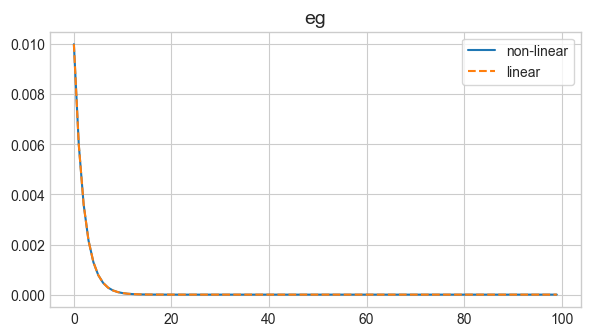


### varnames ###


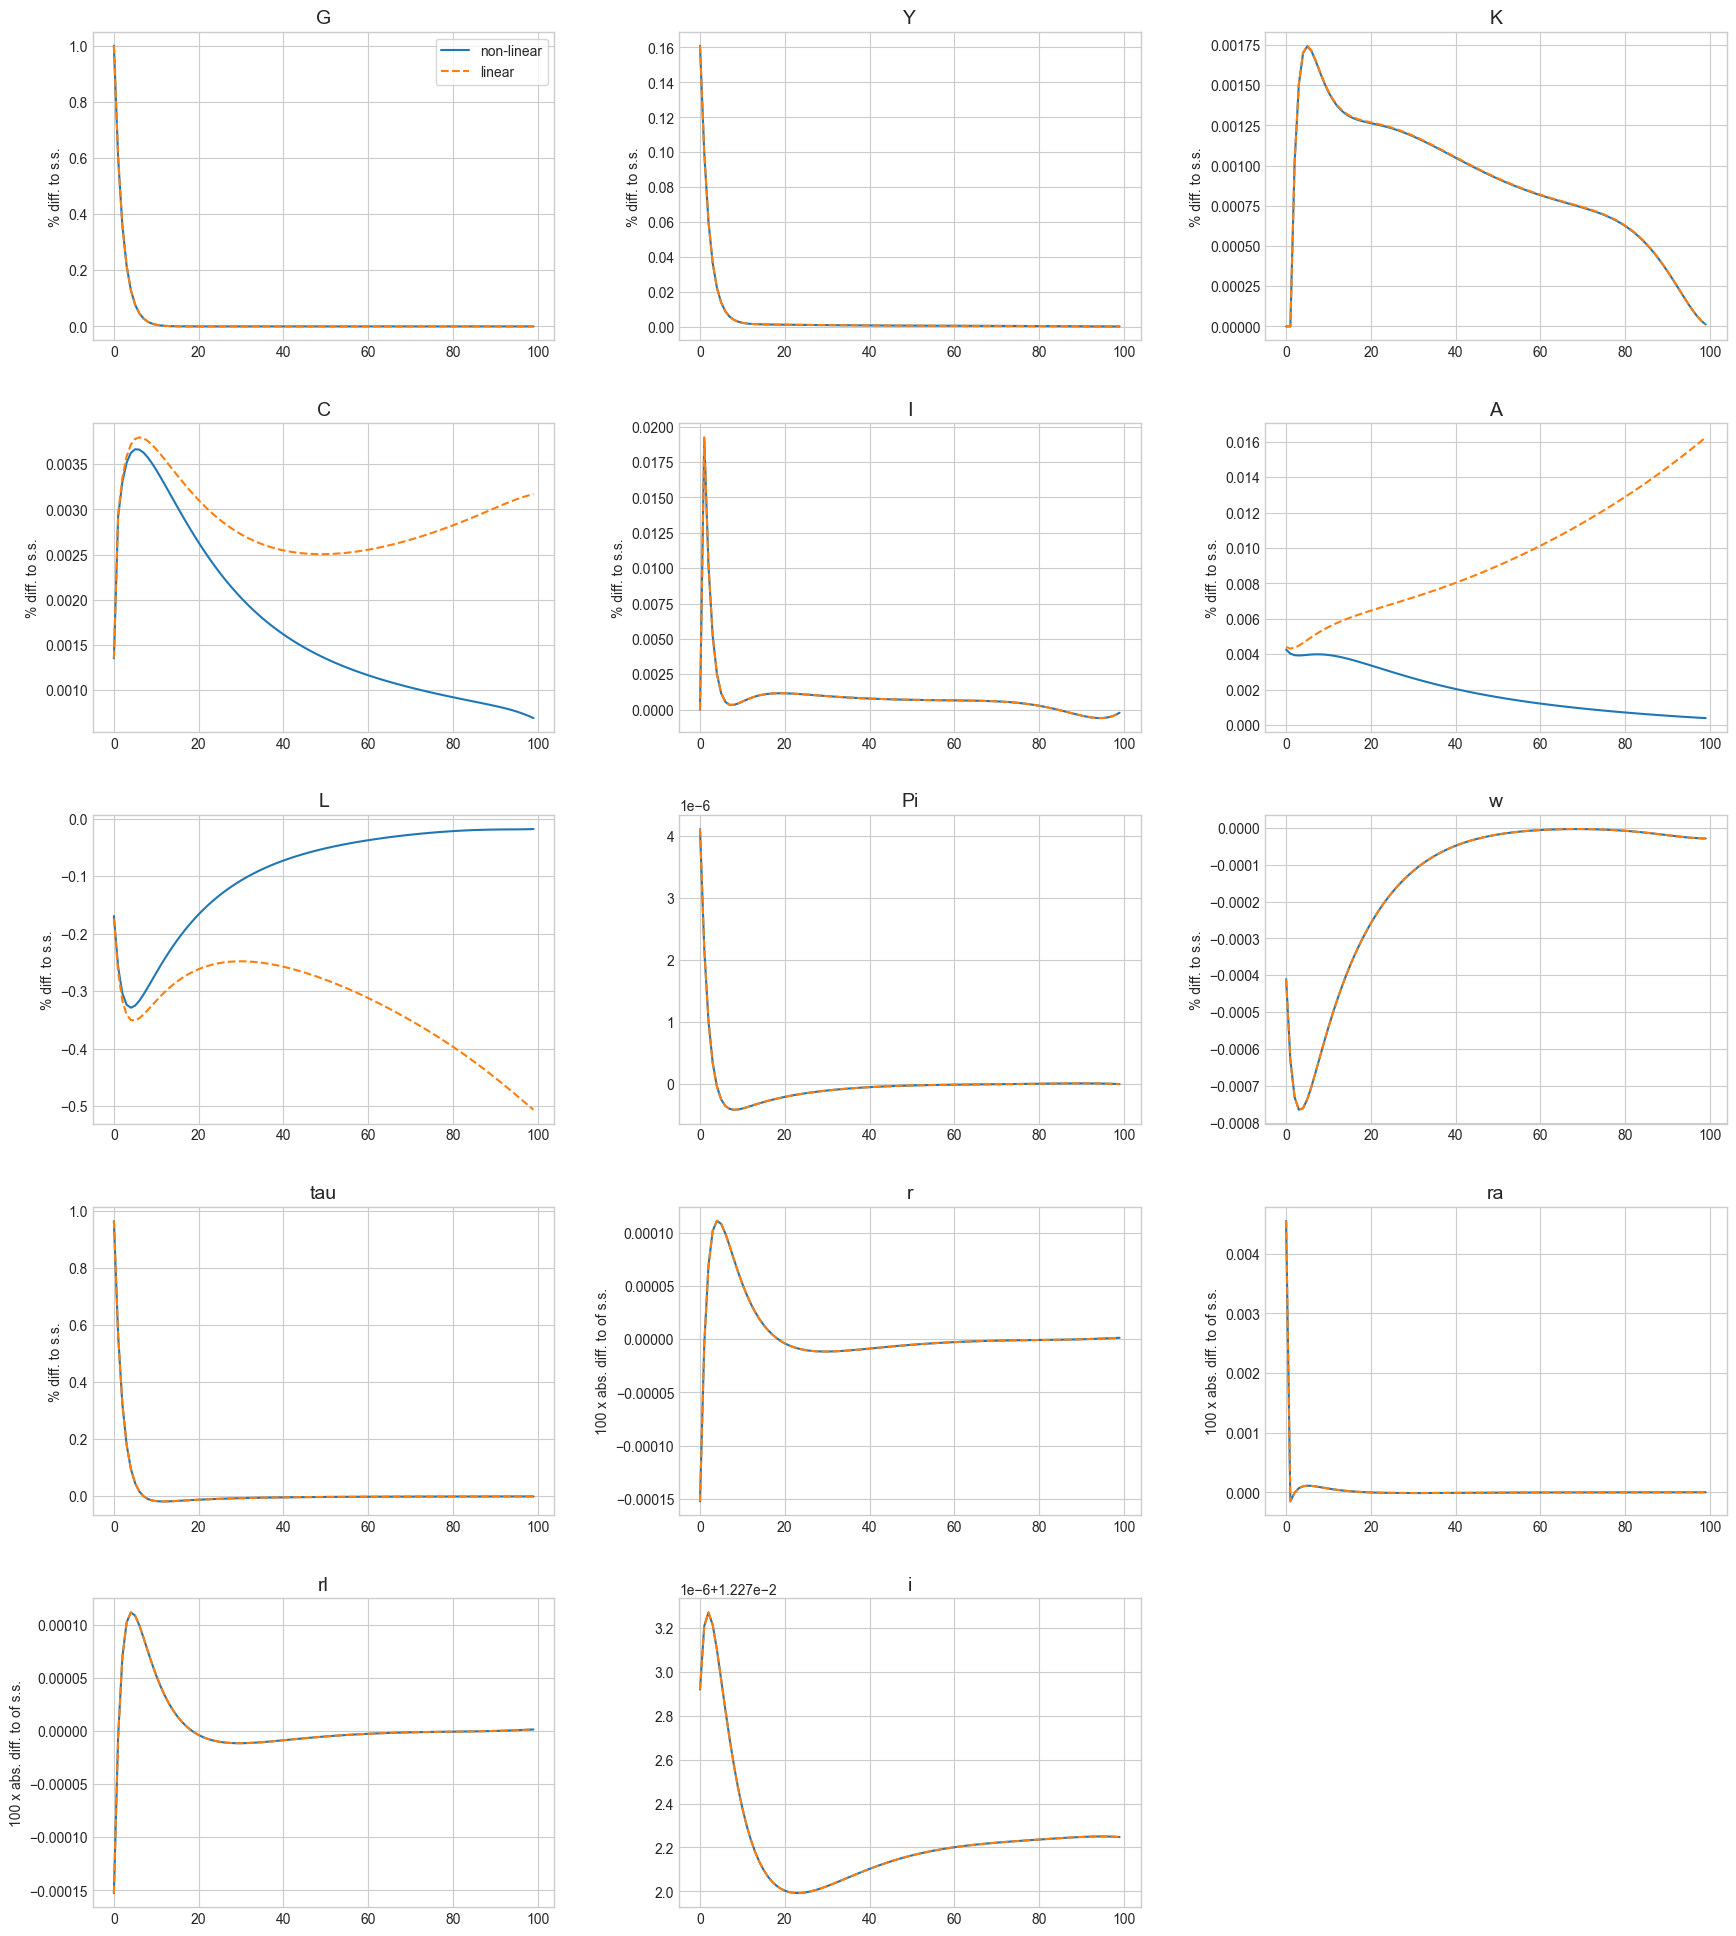


### tagets ###


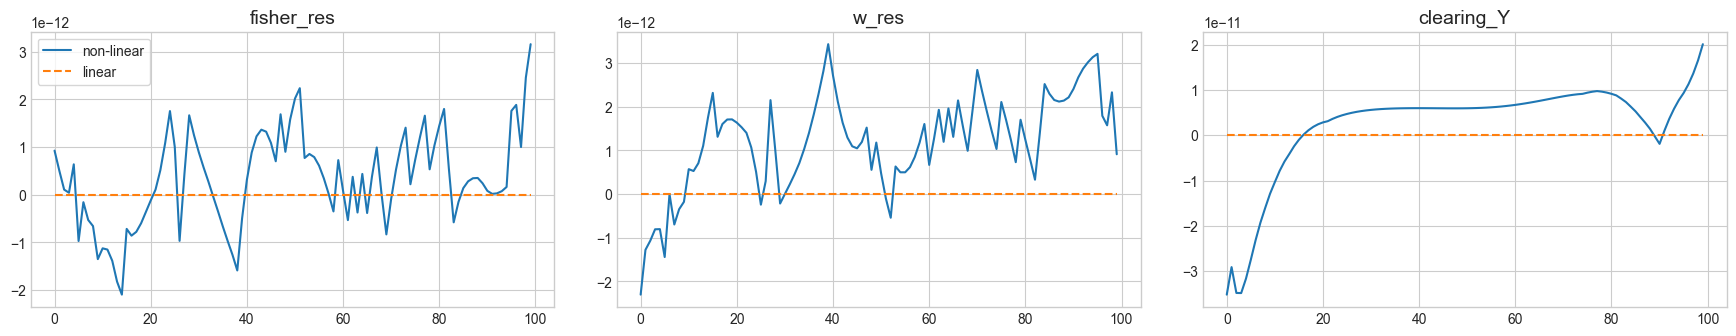

In [25]:
paths = ['G', 'Y','K','C', 'I', 'A', 'L', 'Pi', 'w', 'tau', 'r','ra', 'rl', 'i']
lvl_value = ['eg', 'i', 'Pi']
abs_diff = ['r', 'ra', 'rl']
facs = {'r':100,'ra':100,'rl':100}
# model.show_IRFs(paths,abs_diff=abs_diff,facs=facs,ncols=3,T_max=100)
model.show_IRFs(paths, lvl_value=lvl_value, abs_diff=abs_diff, facs=facs,ncols=3,T_max=100, do_linear=True, do_shocks=True)

# Compare models

In [26]:
def solve_IRF(model, do_print=False, print_progress=True, dx=1e-4):
    """ solve model and find IRF"""

    # find steady state
    if print_progress: print(f'Find steady state for {model.name}')
    model.find_ss(do_print=do_print)
    # compute jacs using fake news method
    if print_progress: print(f'Compute jacs for {model.name}')
    model._compute_jac_hh(dx=dx,do_print=do_print,do_direct=False)
    model._compute_jac(inputs='unknowns',dx=dx,do_print=do_print, parallel=True)
    model._compute_jac(inputs='shocks',dx=dx,do_print=do_print, parallel=True)
    # find transition paths
    if print_progress: print(f'Find transition path for {model.name}')
    model.find_transition_path(do_print=do_print, do_print_unknowns=do_print, do_end_check=False)
    # find IRFs
    if print_progress: print(f'Find IRFs for {model.name}')
    model.find_IRFs(do_print=do_print)
    return model

In [27]:
# create other models to be analyzed
if replication_settings['models']:
    # init containter for all models
    models = {}
    for m, m_keys in replication_settings['models'].items():
        if m_keys['replicate']:
            # init model
            print(f'Model: {m}')
            if 'update_par' in m_keys.keys():
                updated_par = {**replication_settings['update_par'], **m_keys['update_par']}
            else:
                updated_par = replication_settings['update_par']
            models[m] = HANKnoStickyModelClass(name=m, par=updated_par)
            # solve model
            models[m] = solve_IRF(models[m])

Model: tax_financing
Find steady state for tax_financing
Compute jacs for tax_financing
Find transition path for tax_financing
Find IRFs for tax_financing
Model: deficit_financing
Find steady state for deficit_financing
Compute jacs for deficit_financing
Find transition path for deficit_financing
Find IRFs for deficit_financing


### shocks ###


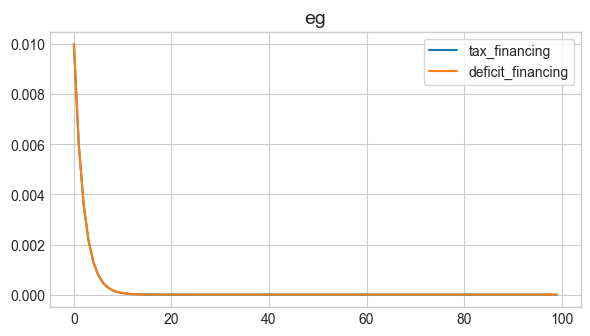


### varnames ###


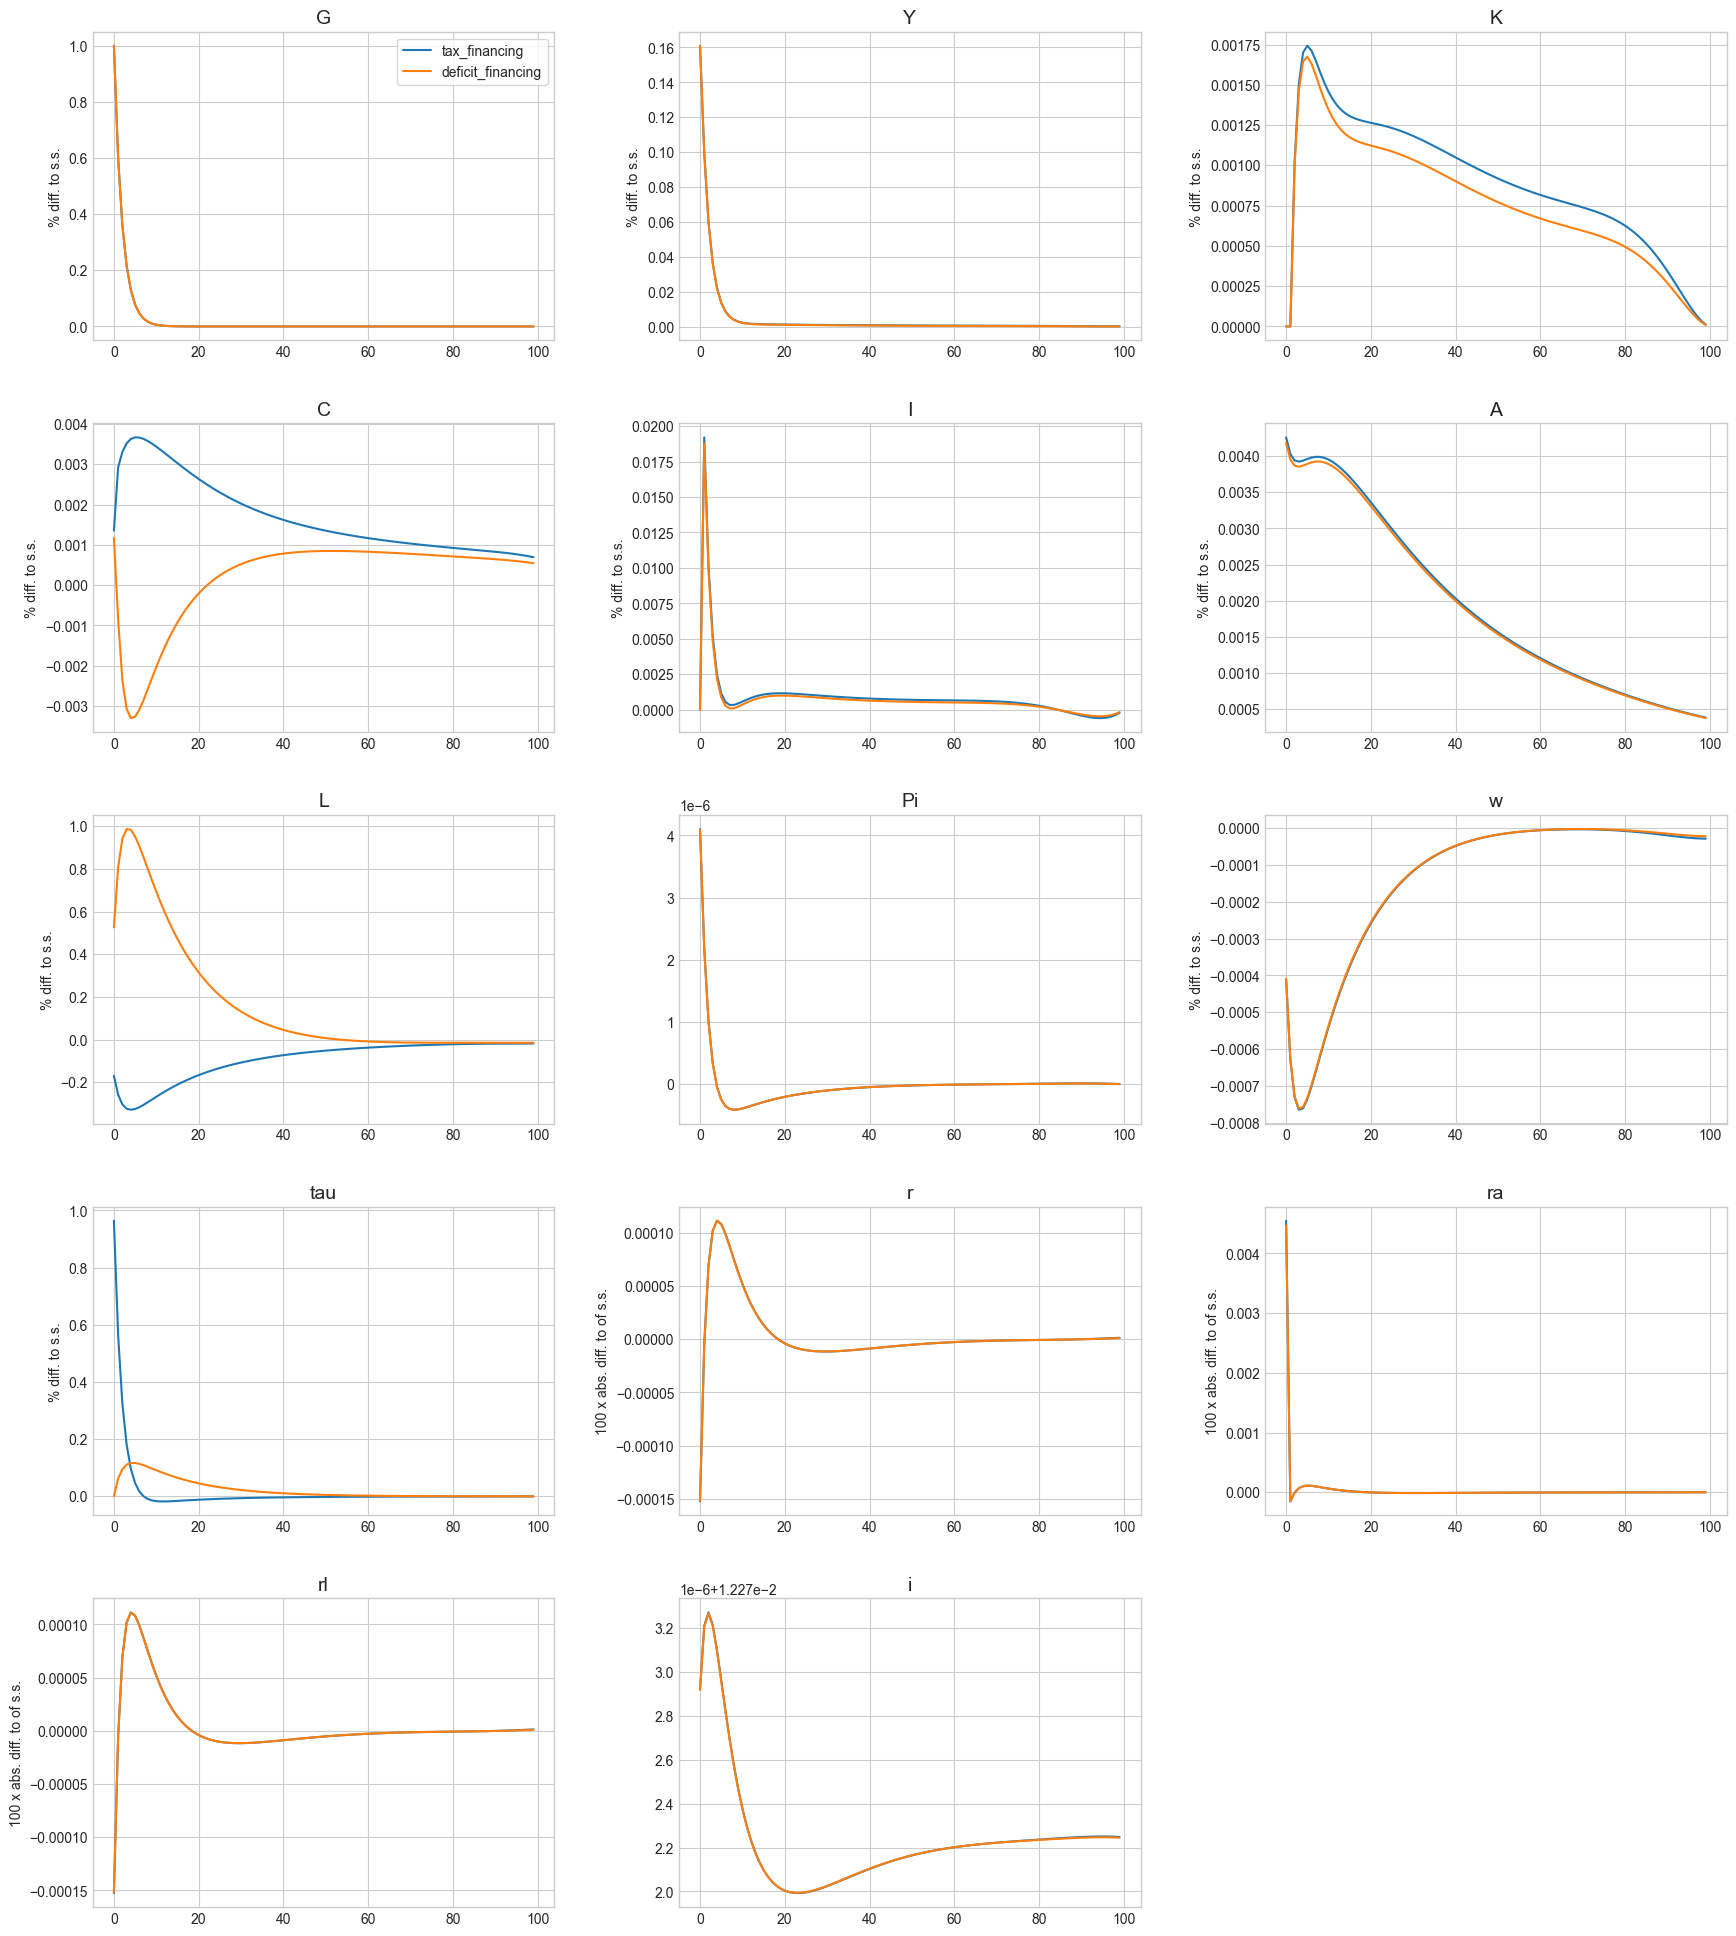


### tagets ###


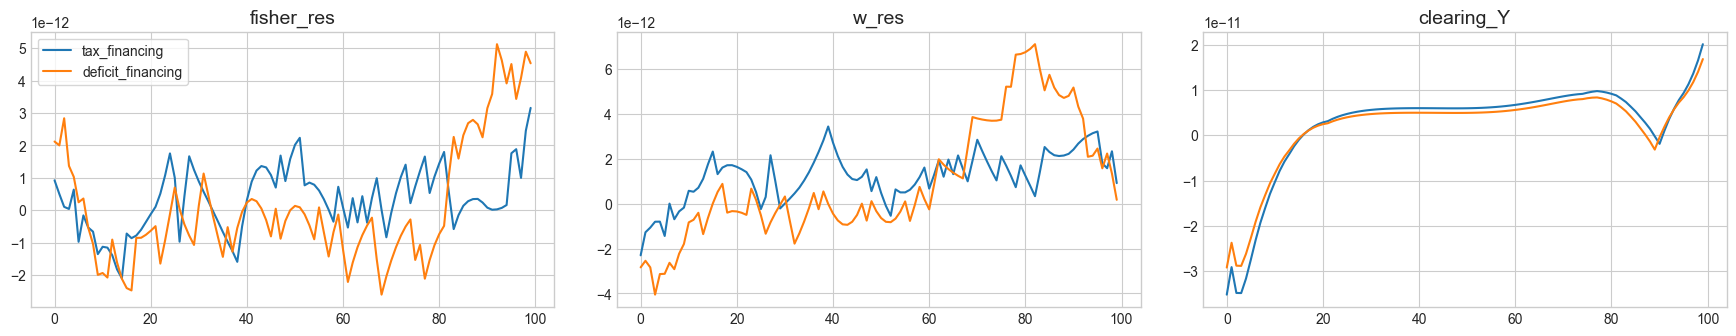

In [28]:
labels_list = list(models.keys())
models_list = list(models.values())
model.compare_IRFs(models_list, labels_list, paths, lvl_value=lvl_value, abs_diff=abs_diff, facs=facs,ncols=3,T_max=100)